## Day 25 Lecture 2 Assignment

In this assignment, we will extend a previous binary model to a multinomial case with three classes. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
def remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f'Deleted {colname} from dataset.')
                    del dataset[colname]

    return dataset

In [83]:
fifa = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv')

In [4]:
fifa.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,80,54,41,87,89,86,91,34,27,22


Our response for our logistic regression model is going to be a new column, "RankingTier", that contains three categories:

- High: Overall score > 75
- Middle: Overall score between 65 and 75
- Low: Overall score < 65

In [85]:
# answer goes here

def tier(n):
    if n < 65:
        return 'Low'
    elif n <= 75: 
        return 'Middle'
    else:
        return 'High'

fifa['Ranking Tier'] = fifa['Overall'].apply(lambda x: tier(x))

# low HDI 
lowtier = fifa[fifa['Ranking Tier'] == 'Low']

# medium HDI
medtier = fifa[fifa['Ranking Tier'] == 'Medium']

# high HDI
hightier = fifa[fifa['Ranking Tier'] == 'High'] 


In [86]:
#fifa.groupby('Ranking Tier').count()


,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Ranking Tier,,,,,,,,,,,,,,,,,,,,,
High,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415,...,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415
Low,6167,6167,6167,6167,6167,6167,6167,6167,6167,6167,...,6167,6167,6167,6167,6167,6167,6167,6167,6167,6167
Middle,8540,8540,8540,8540,8540,8540,8540,8540,8540,8540,...,8540,8540,8540,8540,8540,8540,8540,8540,8540,8540


The next few steps until model training are the same as before: identify and remove highly correlated features, and split the data into a training set (80%) and a test set (20%).

In [87]:
# answer goes here
remove_correlated_features(fifa, .9)

Deleted StandingTackle from dataset.
Deleted SlidingTackle from dataset.


,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Ranking Tier
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,59,94,48,22,94,94,75,96,33,High
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,79,93,63,29,95,82,85,95,28,High
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,49,82,56,36,89,87,81,94,27,High
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,75,91,76,61,87,94,79,88,68,High
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,66,80,54,41,87,89,86,91,34,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16117,238813,J. Lundstram,47,34,38,40,49,25,42,30,...,47,38,46,46,39,52,43,45,40,Low
16118,243165,N. Christoffersson,47,23,52,52,43,36,39,32,...,67,42,47,16,46,33,43,42,22,Low
16119,241638,B. Worman,47,25,40,46,38,38,45,38,...,32,45,32,15,48,43,55,41,32,Low
16120,246268,D. Walker-Rice,47,44,50,39,42,40,51,34,...,48,34,33,22,44,47,50,46,20,Low


In [89]:
y = fifa['Ranking Tier']
x = fifa.drop(['ID','Name','Overall','Ranking Tier'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)


Fit a multinomial logistic regression model (it's a different model than the binary one) using the statsmodels package and print out the coefficient summary. What is the "reference" tier chosen by the model? How do we interpret the coefficients - for example, how does the intepretation of the "Reactions" coefficient for RankingTier=Low differ from the "Reactions" coefficient for RankingTier=Middle?

In [90]:
x_train_const = sm.add_constant(x_train)

In [92]:
# answer goes here
MNL = MNLogit(y, x)
sm_model = sm.MNLogit(y_train, x_train_const).fit() 
print(sm_model.summary())


Optimization terminated successfully.
         Current function value: 0.337841
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:           Ranking Tier   No. Observations:                12897
Model:                        MNLogit   Df Residuals:                    12841
Method:                           MLE   Df Model:                           54
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                  0.6319
Time:                        13:39:58   Log-Likelihood:                -4357.1
converged:                       True   LL-Null:                       -11837.
Covariance Type:            nonrobust   LLR p-value:                     0.000
   Ranking Tier=Low       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  99.0966      2.250     44.035      0.000      94.686     103.507
C

To evaluate test error using cross-validation, we will switch back to scikit-learn. Estimate the test error of this multinomial logistic regression model using 10-fold CV.

Note: scikit-learn's LogisticRegression() function can handle both binary and multinomial regression, and it is automatically able to determine which is appropriate based on the y_train array that is passed. You should be able to reuse previous code with minimal changes required.

In [93]:
logit = LogisticRegression(max_iter=1000)

In [35]:
# answer goes here

cvs = cross_val_score(logit, x_train, y_train, cv=10, scoring='neg_log_loss')




c:\users\juss\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\juss\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

array([-0.44911205, -0.43577152, -0.435735  , -0.42892952, -0.44663545,
       -0.37019038, -0.34119126, -0.44705784, -0.43043543, -0.45790691])

In [ ]:
cvs

c:\users\juss\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [38]:
#print(logit.score(x_train, y_train))
#print(logit.score(x_test, y_test))

0.8047607970845934
0.8043410852713179


In [39]:
#cvs2 = cross_val_score(logit, x_train, y_train, cv=10)


c:\users\juss\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\juss\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [40]:
#cvs2

array([0.80155039, 0.82093023, 0.80775194, 0.82093023, 0.81472868,
       0.84651163, 0.84651163, 0.80760279, 0.81691234, 0.79906905])

In [96]:
logit.fit(x_train, y_train)

c:\users\juss\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

As we did in the previous exercise, train a multinomial logistic regression on the training data, make predictions on the 20% holdout test data, then:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Comment on the performance of the model.

In [97]:
# answer goes here

y_pred = logit.predict(x_test)
Y_pred_pro = logit.predict_proba(x_test)

clarep = classification_report(y_test, y_pred)
print(clarep)

              precision    recall  f1-score   support

        High       0.81      0.43      0.56       285
         Low       0.84      0.84      0.84      1218
      Middle       0.81      0.87      0.84      1722

    accuracy                           0.82      3225
   macro avg       0.82      0.71      0.75      3225
weighted avg       0.82      0.82      0.81      3225



In [98]:
#label = ['High', 'Low', 'Medium']
print(confusion_matrix(y_test, y_pred, labels=['Low', 'Middle', 'High']))


[[1024  194    0]
 [ 194 1499   29]
 [   0  163  122]]


In [64]:
#confusion_matrix(y_test, y_pred)

In [99]:
y_bin = pd.get_dummies(y_test)
y_pred_prob = logit.predict_proba(x_test)


In [102]:
logit.classes_

array(['High', 'Low', 'Middle'], dtype=object)

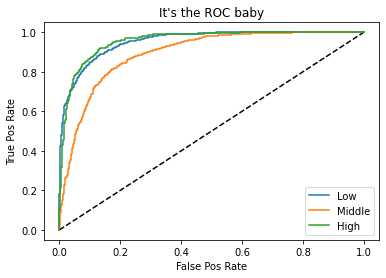

In [105]:
from sklearn.metrics import roc_curve, roc_auc_score 

plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, thresholds = roc_curve(y_bin['Low'], y_pred_prob[:,1]) 
line0, = plt.plot(fpr, tpr, label='Low')
fpr1, tpr1, thresholds = roc_curve(y_bin['Middle'], y_pred_prob[:,2]) 
line1, = plt.plot(fpr1, tpr1, label='Middle')
fpr2, tpr2, thresholds = roc_curve(y_bin['High'], y_pred_prob[:,0]) 
line2, = plt.plot(fpr2, tpr2, label='High')

plt.legend()
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.title("It's the ROC baby")
plt.show()